<a href="https://colab.research.google.com/github/Rkk-i8/Blepharoptosis_refractive-change/blob/main/Blepharoptosis_OLS_VIF_Ridge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# ❶ Google Drive をマウント
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# ❷ ライブラリ読み込み
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# ❸ エクセルファイル読み込み
file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂乱視/不正乱視/眼瞼下垂不正乱視.xlsx"
sheet_name = "CASIA対象症例"

df = pd.read_excel(file_path, sheet_name=sheet_name)


【カテゴリ変数の件数】

sex:
sex
0    109
1     57
Name: count, dtype: int64

side:
side
1    84
0    82
Name: count, dtype: int64

intraocular_surg:
intraocular_surg
1    117
0     49
Name: count, dtype: int64

glaucoma:
glaucoma
0    116
1     50
Name: count, dtype: int64

【数値変数の平均±標準偏差】
age: 75.42 ± 8.67
MRD-1_pre: 0.42 ± 1.24
MRD-1_post: 3.31 ± 0.99
ΔMRD-1: 2.89 ± 1.38
levator function_pre: 9.17 ± 2.35
HOAs_pre: 0.31 ± 0.23
HOAs_post: 0.35 ± 0.25
ΔHOAs: 0.03 ± 0.12
                            OLS Regression Results                            
Dep. Variable:                  ΔHOAs   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.772
Date:                Fri, 18 Jul 2025   Prob (F-statistic):             0.0775
Time:                        09:13:21   Log-Likelihood:                 130.15
No. Observations:                 166   AIC:                   

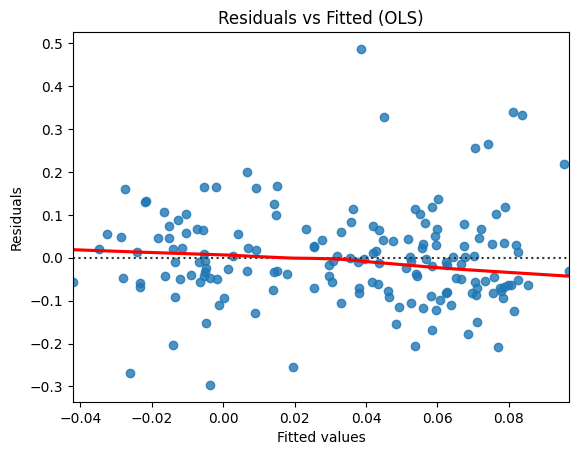

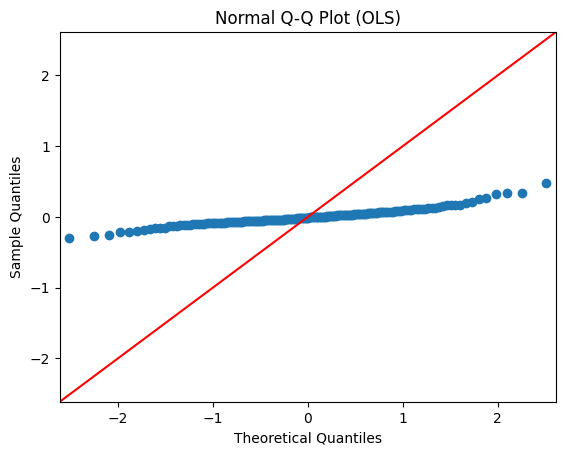

In [8]:
# ❹ 基本統計量の確認（カテゴリの件数、数値の平均±SD）
cols_binary = ["sex", "side", "intraocular_surg", "glaucoma"]
cols_numeric = [
    "age", "MRD-1_pre", "MRD-1_post", "ΔMRD-1",
    "levator function_pre", "HOAs_pre", "HOAs_post", "ΔHOAs"
]

print("【カテゴリ変数の件数】")
for col in cols_binary:
    print(f"\n{col}:\n{df[col].value_counts()}")

print("\n【数値変数の平均±標準偏差】")
for col in cols_numeric:
    mean = df[col].mean()
    std = df[col].std()
    print(f"{col}: {mean:.2f} ± {std:.2f}")

# ❺ 回帰分析対象の列を定義し、欠損を除去
regression_columns = [
    "ΔHOAs", "age", "sex", "side", "MRD-1_pre", "ΔMRD-1",
    "levator function_pre", "HOAs_pre", "intraocular_surg", "glaucoma"
]
df_reg = df[regression_columns].dropna()
X = df_reg.drop(columns=["ΔHOAs"])
y = df_reg["ΔHOAs"]

# ❻ OLS線形回帰の実施
X_const = sm.add_constant(X)
ols_model = sm.OLS(y, X_const).fit()
print(ols_model.summary())

# ❼ 残差プロットとQ-Qプロットで診断
residuals = ols_model.resid
fitted_vals = ols_model.fittedvalues

# 残差 vs 予測値
plt.figure()
sns.residplot(x=fitted_vals, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (OLS)")
plt.show()

# Q-Qプロット
sm.qqplot(residuals, line='45')
plt.title("Normal Q-Q Plot (OLS)")
plt.show()


In [9]:
# ❽ 多重共線性チェック（VIF）
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\n【VIF（多重共線性の指標）】")
print(vif_df)



【VIF（多重共線性の指標）】
               Variable        VIF
0                   age  27.596118
1                   sex   1.645400
2                  side   2.083608
3             MRD-1_pre   2.487492
4                ΔMRD-1  10.411552
5  levator function_pre  14.115562
6              HOAs_pre   3.088988
7      intraocular_surg   3.782453
8              glaucoma   1.802486


In [10]:
# ❾ リッジ回帰（RidgeCV + 標準化）
alphas = np.logspace(-3, 3, 100)
ridge_pipeline = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, cv=5))
ridge_pipeline.fit(X, y)

# 結果の表示
ridge = ridge_pipeline.named_steps['ridgecv']
scaler = ridge_pipeline.named_steps['standardscaler']
coefficients = ridge.coef_
best_alpha = ridge.alpha_

print(f"\n【リッジ回帰結果】\n最適なα: {best_alpha:.4f}")
for var, coef in zip(X.columns, coefficients):
    print(f"{var}: {coef:.6f}")



【リッジ回帰結果】
最適なα: 1000.0000
age: 0.001232
sex: -0.004162
side: 0.000187
MRD-1_pre: -0.000246
ΔMRD-1: 0.000137
levator function_pre: -0.001736
HOAs_pre: -0.001359
intraocular_surg: 0.000645
glaucoma: 0.000908
